# EECS 498-008/598-008 Assignment 6-2: Generative Adversarial Networks 

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Bhavya Pulagam, #93153306

# Generative Adversarial Networks (GANs)

So far in this course, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will alternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stability and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.



## Setup code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'gan.py', 'generative_adversarial_networks.ipynb', 'a6_helper.py', 'vae.py', 'variational_autoencoders.ipynb']
```

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A6'
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from gan.py!
Hello from a6_helper.py!
```

as well as the last edit time for the file `gan.py`.


In [3]:
import sys

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from gan import hello_gan
hello_gan()

from a6_helper import hello_helper
hello_helper()

Hello from gan.py!
Hello from a6_helper.py!


In [4]:
import os
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from eecs598.grad import rel_error
from eecs598.utils import reset_seed

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Note that if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

We will be using `torch.float = torch.float32` for all operations.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [5]:
if torch.cuda.is_available():
  print('Good to go!')
else:

  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


 Now we'll import some helper functions from the `a6_helper.py` we've provided to help us visualize the MNIST dataset, verify the neural networks you implement, and initialize weights in the `torch.nn` modules you'll write.

In [6]:
from a6_helper import show_images, count_params, initialize_weights

dtype = torch.float
device = 'cuda'
answers = {}

## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable, we will be working on the CIFAR10 dataset.The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

In [10]:
batch_size = 128
image_size = 32
NOISE_DIM = 96

# image transforms
transform = T.Compose([
    #T.Resize(image_size),
    T.ToTensor(),
    T.Normalize((0.43, 0.43, 0.43), 
    (0.43, 0.43, 0.43)),
])

dataset = dset.CIFAR10(root='data', download=True, transform=T.ToTensor())

loader_cifartrain = DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=3)


Files already downloaded and verified


## Random Noise
The first step is to generate uniform noise from -1 to 1 with shape `[batch_size, noise_dim]`

Hint: use `torch.rand`.

Implement `sample_noise` and verify all tests pass below

In [12]:
from gan import sample_noise
reset_seed(0)
batch_size = 3
noise_dim = 4
device = 'cuda'
z = sample_noise(batch_size, noise_dim)
assert z.shape == (batch_size, noise_dim)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Discriminator
Our first step is to build a discriminator. All fully connected layers should include bias terms. The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input_size 256 and output size 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer with input size 256 and output size 1
 
Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; for the LeakyReLU nonlinearities in the architecture above we set $\alpha=0.01$.
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image. 

Implement `discriminator` in `gan.py` and test your solution by running the cell below. Be sure to use `nn.Sequential` for this model definition and all future models in this notebook.

In [13]:
from gan import discriminator

def test_discriminator(true_count=852737):
  model = discriminator()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in discriminator. Check your achitecture.')
  else:
    print('Correct number of parameters in discriminator.')     

test_discriminator()

852737
Correct number of parameters in discriminator.


# Generator
Now to build the generator network:
 * Fully connected layer from noise_dim to 1024
 * `ReLU`
 * Fully connected layer with size 1024 
 * `ReLU`
 * Fully connected layer with size 784
 * `TanH` (to clip the image to be in the range of [-1,1])

Implement `generator` in `gan.py` and test your solution by running the cell below.

In [14]:
from gan import generator

def test_generator(true_count=4203520):
  model = generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_generator()

4203520
Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 < D(x) < 1$ which results from squashing the raw score from the discriminator through a sigmoid function. However for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above -- instead we will implement the sigmoid as part of the loss function.

**HINTS**: You can use the function [`torch.nn.functional.binary_cross_entropy_with_logits`](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy-with-logits) to compute these losses in a numerically stable manner.

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss (with logits) is defined as:

$$ bce(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.

A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. Make sure you cast these labels to the correct data type using the global `dtype` variable, for example:

`true_labels = torch.ones(size, device=device)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

Implement `discriminator_loss` and `generator_loss` in `gan.py` and test your solution by running the cell below.. You should see errors < `1e-7`.

In [15]:
from gan import discriminator_loss

device = 'cuda'
answers['logits_fake'] = torch.tensor(
  [-1.80865868,  0.09030055, -0.4428902 , -0.07879368, -0.37655044,
    0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
  dtype=dtype, device=device)
answers['d_loss_true'] = torch.tensor(1.8423983904443109, dtype=dtype, device=device)
answers['logits_real'] = torch.tensor(
  [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
   -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
  dtype=dtype, device=device)

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
  d_loss = discriminator_loss(logits_real, logits_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 0


In [16]:
from gan import generator_loss

device = 'cuda'
answers['g_loss_true'] = torch.tensor(0.771286196423346, dtype=dtype, device=device)

def test_generator_loss(logits_fake, g_loss_true):
  g_loss = generator_loss(logits_fake)
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 0


# Optimizing our loss


Next, you'll define a function that returns an `optim.Adam` optimizer for the given model with a 1e-3 learning rate, beta1=0.5, beta2=0.999. We'll use this to construct optimizers for the generators and discriminators for the rest of the notebook in `get_optimizer`.

Implement `get_optimizer` in `gan.py` before moving forward in the notebook

# Training a GAN!

We provide you the main training loop... you won't need to change this function, but we encourage you to read through and understand it. 

In [91]:
from a6_helper import show_cifar_images
import torchvision.utils as tvutils
def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, save_filename, show_every=1000, 
              batch_size=128, noise_size=96, num_epochs=25):
  """
  Train a GAN!
  
  Inputs:
  - D, G: PyTorch models for the discriminator and generator
  - D_solver, G_solver: torch.optim Optimizers to use for training the
    discriminator and generator.
  - discriminator_loss, generator_loss: Functions to use for computing the generator and
    discriminator loss, respectively.
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - noise_size: Dimension of the noise to use as input to the generator.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_cifartrain:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.view(-1, 1024*3).to(device)
      logits_real = D(2* (real_data - 0.5))

      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images)

      d_total_error = discriminator_loss(logits_real, logits_fake)
      d_total_error.backward()        
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size, noise_size, dtype=real_data.dtype, device=real_data.device)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images)
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()

      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu()#.numpy()
        show_cifar_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1

    imgs_numpyfake = fake_images.data.cpu()
    show_cifar_images(imgs_numpyfake[0:6])
    plt.savefig(f'images/fakes/fake{epoch}.jpg')
    imgs_numpyreal = real_data.data.cpu()
    show_cifar_images(imgs_numpyreal[0:6])
    plt.savefig(f'images/reals/realdata{epoch}.jpg')

    if epoch == num_epochs - 1:
      show_cifar_images(imgs_numpy[0:16])
      plt.savefig(os.path.join(save_filename))
      

Now run the cell below to train your first GAN! Your last epoch results will be stored in `fc_gan_results.jpg` for you to submit to the autograder

Iter: 0, D: 1.403, G:0.6995


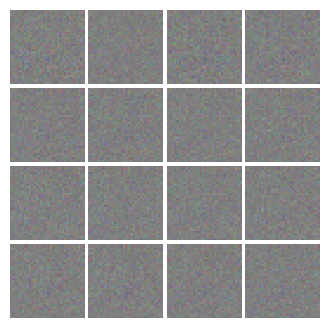


Iter: 1000, D: 1.36, G:2.995


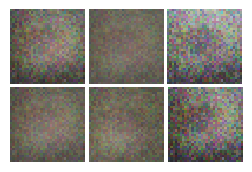

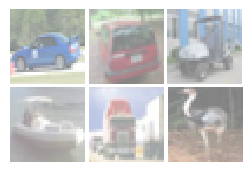

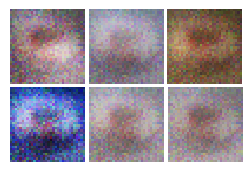

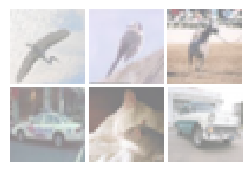

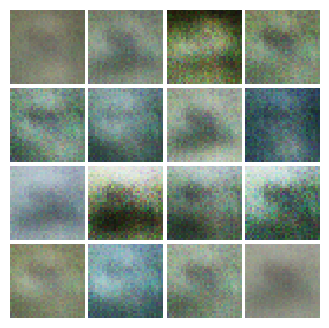


Iter: 2000, D: 1.211, G:1.224


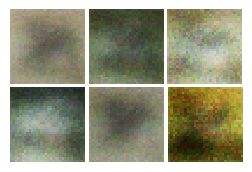

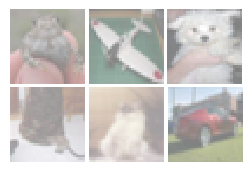

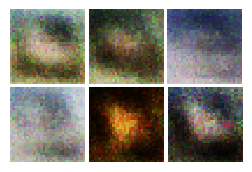

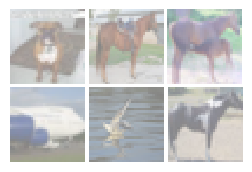

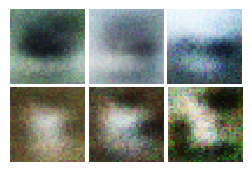

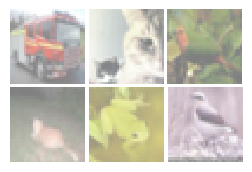

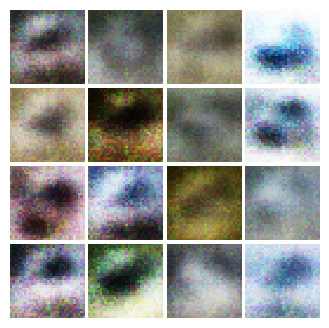


Iter: 3000, D: 1.236, G:0.982


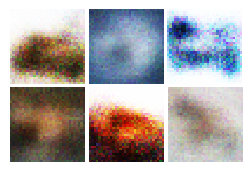

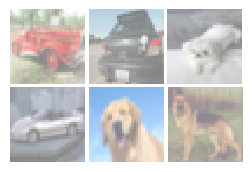

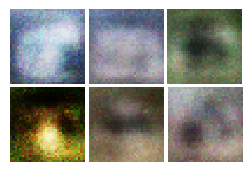

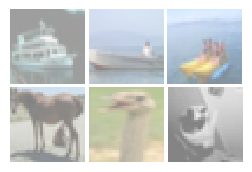

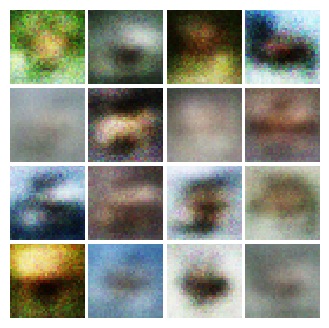


Iter: 4000, D: 1.166, G:0.9579


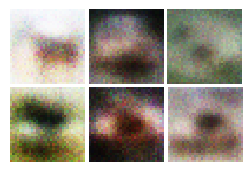

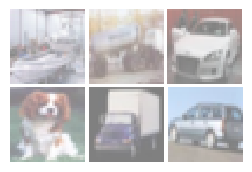

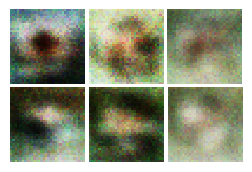

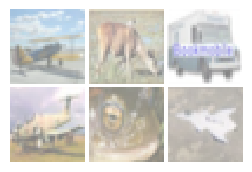

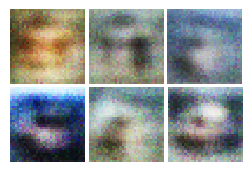

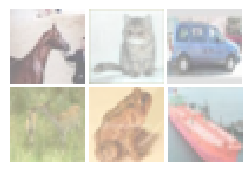

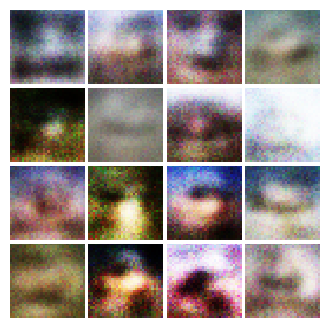


Iter: 5000, D: 1.438, G:0.8448


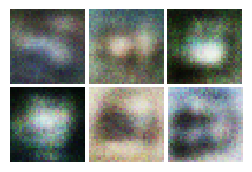

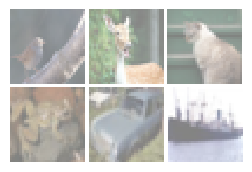

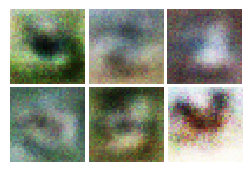

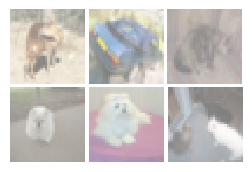

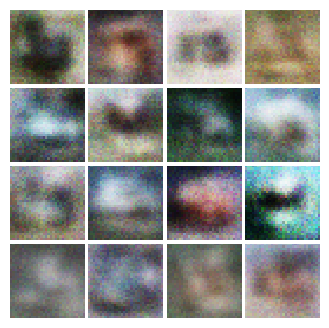


Iter: 6000, D: 1.335, G:0.731


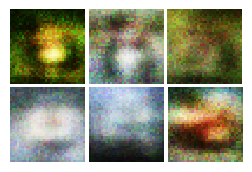

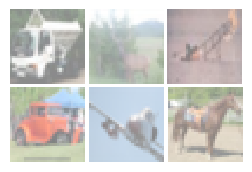

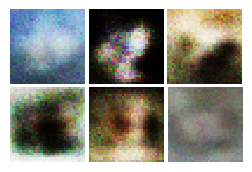

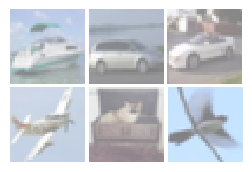

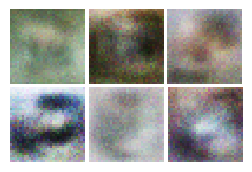

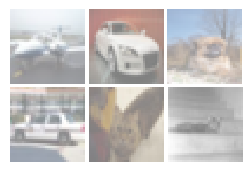

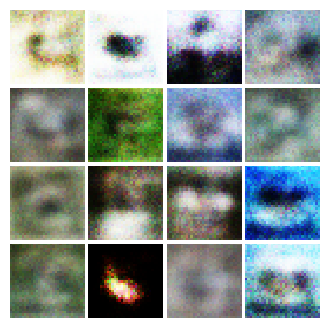


Iter: 7000, D: 1.334, G:0.7106


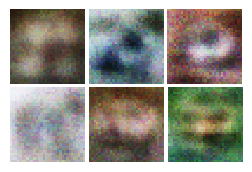

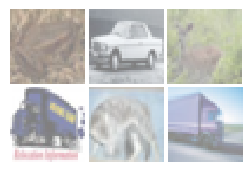

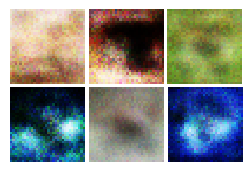

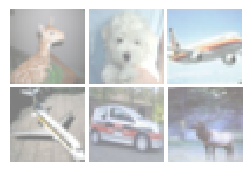

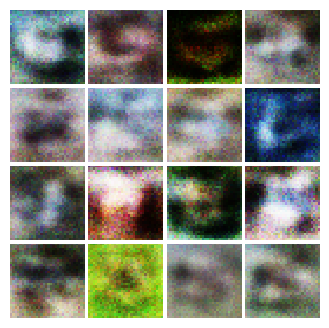


Iter: 8000, D: 1.387, G:0.9372


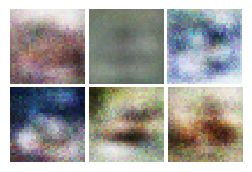

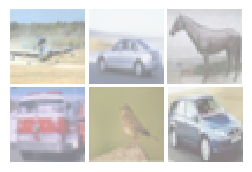

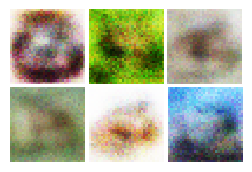

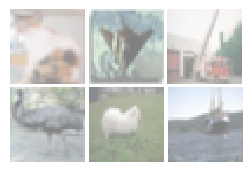

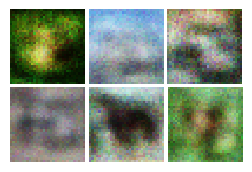

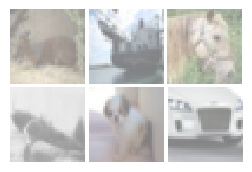

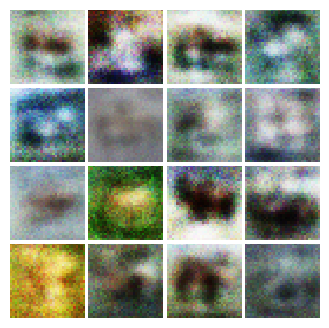


Iter: 9000, D: 1.384, G:0.7251


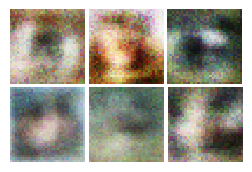

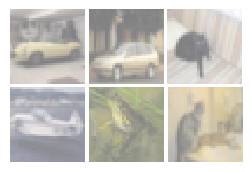

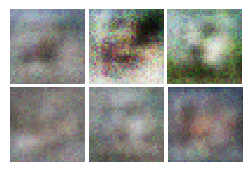

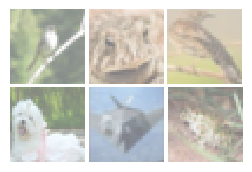

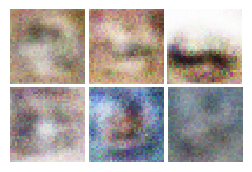

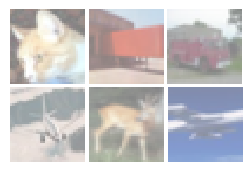

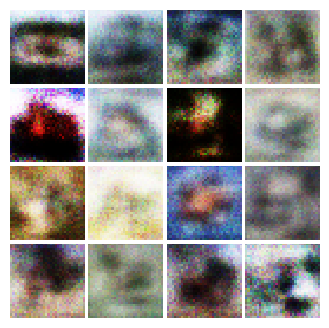

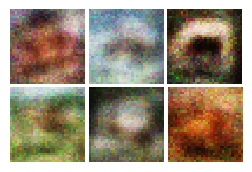

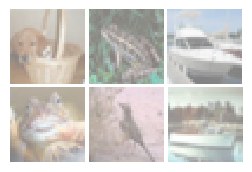

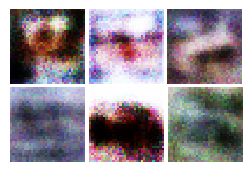

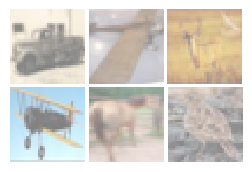

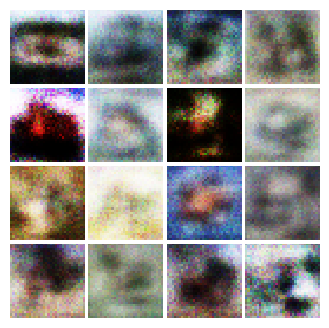

In [92]:
from gan import get_optimizer
reset_seed(0)

# Make the discriminator
D = discriminator().to(device)

# Make the generator
G = generator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, 'fc_gan_results.jpg')

**The above image-grids contain grids of fake and real images for every epoch(25) and the trained model image for every 1000 iterations**

In [93]:
from FID import fidScore
fcgan_FID = []
for i in range(1,26):
    fids = fidScore('images/fakes', 'images/reals',i, 1)
    print(f'Epoch:{i} and FID Score: {fids}', flush=True)
    fcgan_FID.append(fids)
    

Epoch:1 and FID Score: 231.373844242262
Epoch:2 and FID Score: 173.52970747894503
Epoch:3 and FID Score: 102.83239371722811
Epoch:4 and FID Score: 72.30401732895004
Epoch:5 and FID Score: 55.529479135847254
Epoch:6 and FID Score: 44.9891586623404
Epoch:7 and FID Score: 37.77515136184913
Epoch:8 and FID Score: 32.53679919673226
Epoch:9 and FID Score: 28.564540837492785
Epoch:10 and FID Score: 25.45100571032946
Epoch:11 and FID Score: 22.9460603869954
Epoch:12 and FID Score: 20.887819720297244
Epoch:13 and FID Score: 19.166975252510056
Epoch:14 and FID Score: 17.707099427454814
Epoch:15 and FID Score: 16.453174347230636
Epoch:16 and FID Score: 15.364597571688634
Epoch:17 and FID Score: 14.410760289030975
Epoch:18 and FID Score: 13.568155418921386
Epoch:19 and FID Score: 12.818435136363533
Epoch:20 and FID Score: 12.147069294055889
Epoch:21 and FID Score: 11.542404879289819
Epoch:22 and FID Score: 10.99498617149959
Epoch:23 and FID Score: 10.49706215226388
Epoch:24 and FID Score: 10.04221

Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000.

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$

and the discriminator loss:

$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In these equations, we assume that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

Verify your implementation below, you should see relative errors of < `1e-7` or less

In [72]:
from gan import ls_discriminator_loss
from gan import ls_generator_loss

answers['d_loss_lsgan_true'] = torch.tensor(1.8770293614440594, dtype=dtype, device=device)
answers['g_loss_lsgan_true'] = torch.tensor(0.816954786997558, dtype=dtype, device=device)
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
  d_loss = ls_discriminator_loss(score_real, score_fake)
  g_loss = ls_generator_loss(score_fake)
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Run the following cell to train your model! Your last epoch results will be stored in `ls_gan_results.jpg` for you to submit to the autograder

Iter: 0, D: 0.5085, G:0.4536


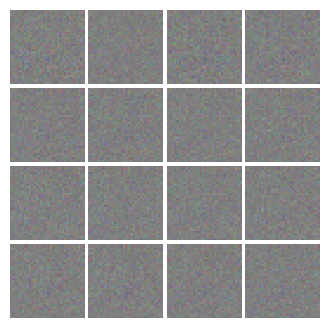


Iter: 1000, D: 0.1814, G:0.2919


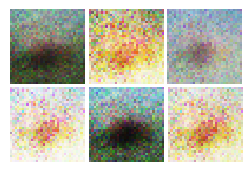

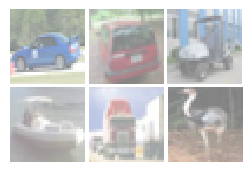

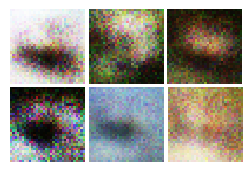

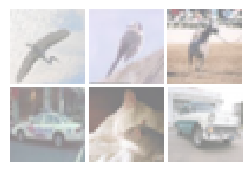

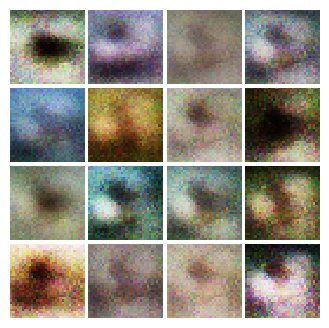


Iter: 2000, D: 0.2659, G:0.1696


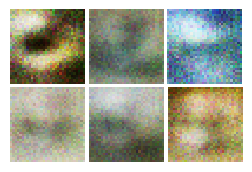

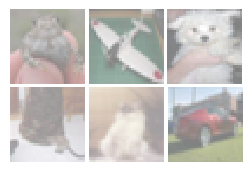

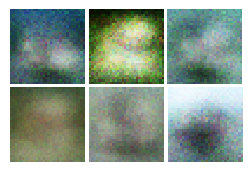

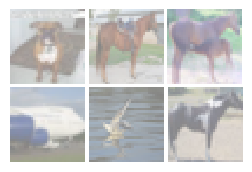

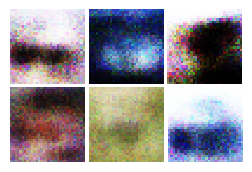

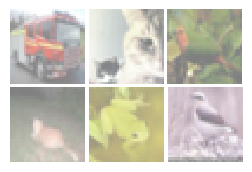

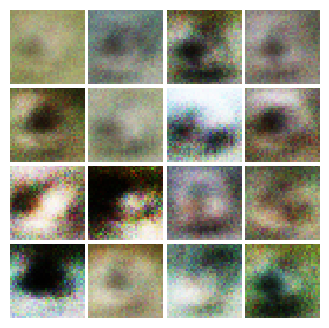


Iter: 3000, D: 0.2353, G:0.2272


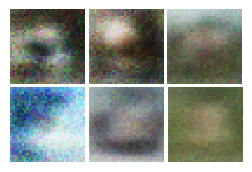

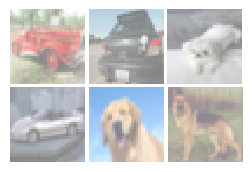

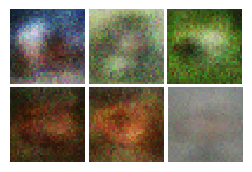

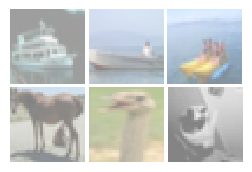

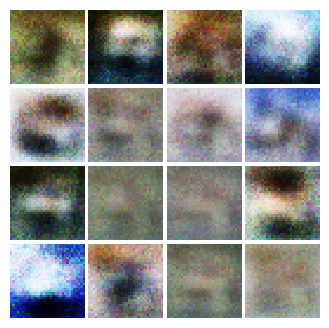


Iter: 4000, D: 0.2556, G:0.1389


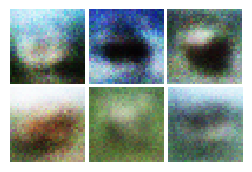

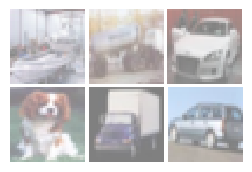

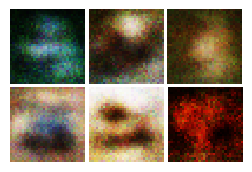

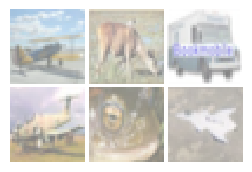

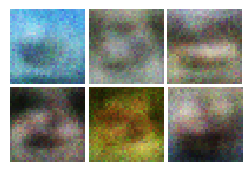

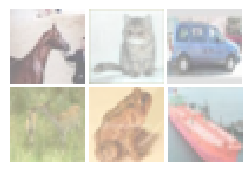

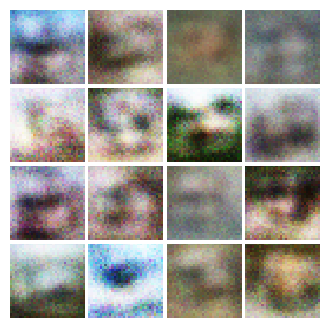


Iter: 5000, D: 0.2467, G:0.147


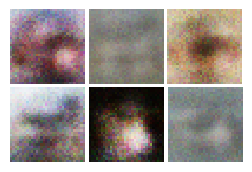

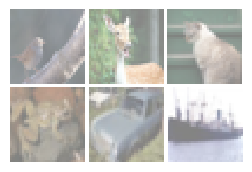

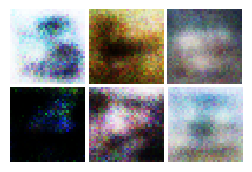

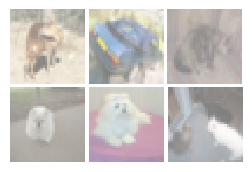

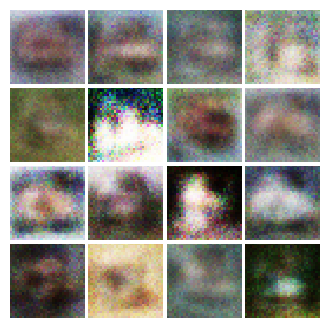


Iter: 6000, D: 0.2606, G:0.1416


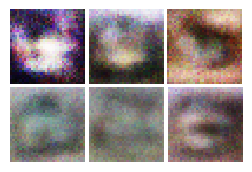

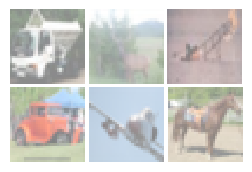

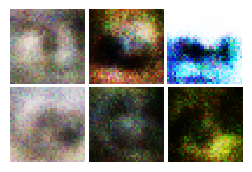

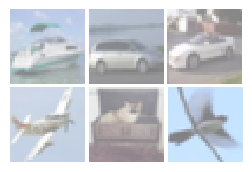

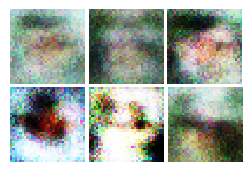

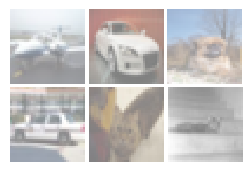

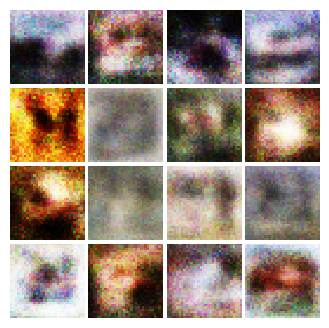


Iter: 7000, D: 0.2689, G:0.1367


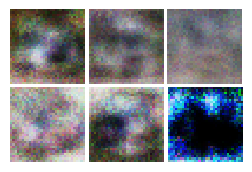

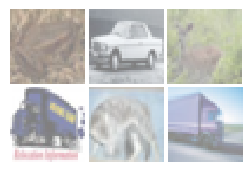

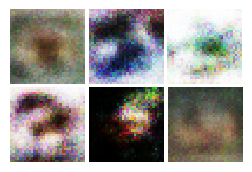

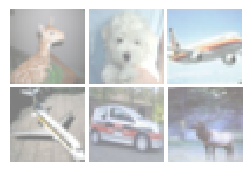

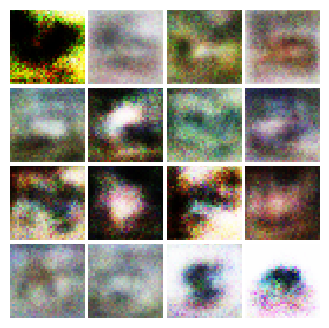


Iter: 8000, D: 0.2425, G:0.109


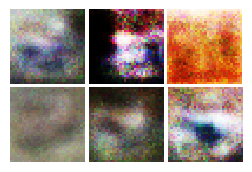

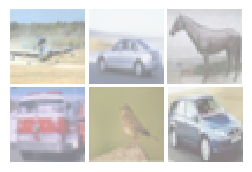

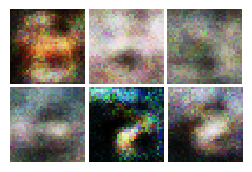

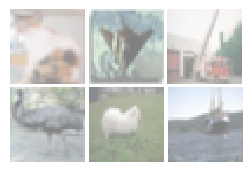

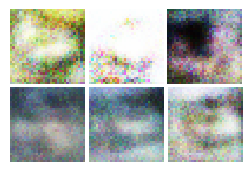

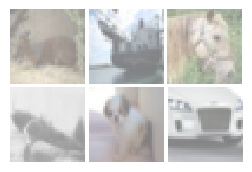

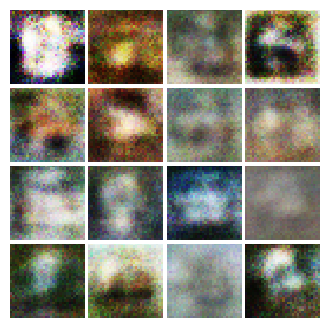


Iter: 9000, D: 0.2565, G:0.1256


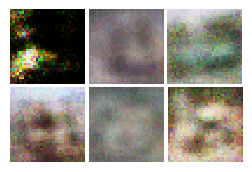

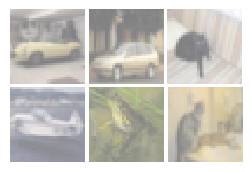

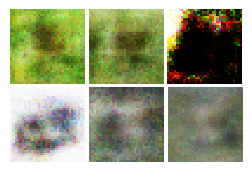

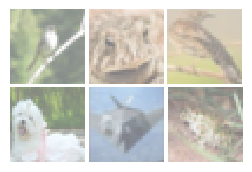

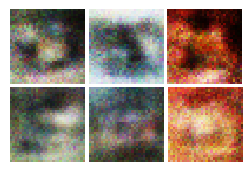

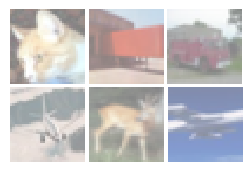

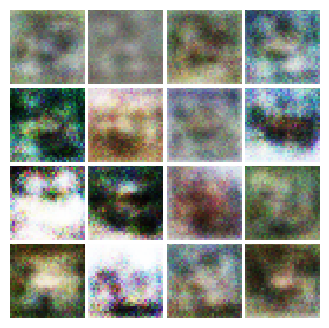

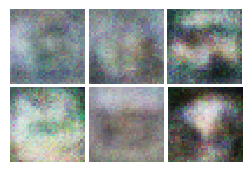

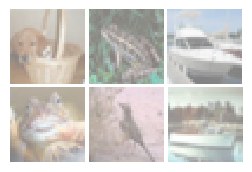

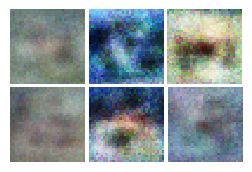

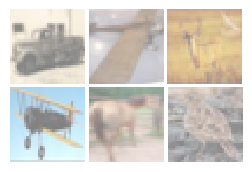

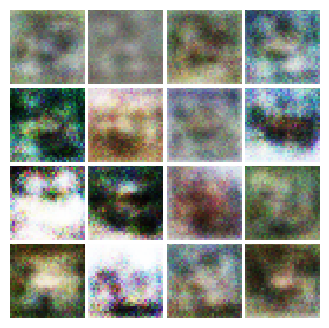

In [73]:
reset_seed(0)

D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, 'ls_gan_results.jpg')

**The above image-grids contain grids of fake and real images for every epoch(25) and the trained model image for every 1000 iterations**

In [74]:
from FID import fidScore
lsgan_FID = []
for i in range(1,26):
    fids = fidScore('images/fakes','images/reals',  i, 1)
    print(f'Epoch:{i} and FID Score: {fids}', flush=True)
    lsgan_FID.append(fids)

Epoch:1 and FID Score: 189.7624842982512
Epoch:2 and FID Score: 142.3208501036816
Epoch:3 and FID Score: 84.33826080593013
Epoch:4 and FID Score: 59.30032716670897
Epoch:5 and FID Score: 45.54264687176601
Epoch:6 and FID Score: 36.897975201175996
Epoch:7 and FID Score: 30.9813873477341
Epoch:8 and FID Score: 26.685138899290514
Epoch:9 and FID Score: 23.427282191354735
Epoch:10 and FID Score: 20.873707137256382
Epoch:11 and FID Score: 18.819270160141087
Epoch:12 and FID Score: 17.131198553015018
Epoch:13 and FID Score: 15.719843405822495
Epoch:14 and FID Score: 14.522522928704774
Epoch:15 and FID Score: 13.49411259900338
Epoch:16 and FID Score: 12.60131361238605
Epoch:17 and FID Score: 11.819021303037417
Epoch:18 and FID Score: 11.127957071803529
Epoch:19 and FID Score: 10.51307174211463
Epoch:20 and FID Score: 9.962449976228143
Epoch:21 and FID Score: 9.46653257220867
Epoch:22 and FID Score: 9.017565634366715
Epoch:23 and FID Score: 8.609192000264795
Epoch:24 and FID Score: 8.236152056

# Deeply Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks.

#### Discriminator
We will use a discriminator
* Reshape(Use `nn.Flatten`!)
* Fully ConnectedFully (1024*3, 256)
* Leaky ReLU(alpha=0.01)
* Fully ConnectedFully (256, 256)
* Leaky ReLU(alpha=0.01)
* Flatten(256,1)
* Fully Connected with output size 1


In [77]:
from gan import build_dc_classifier

data = next(enumerate(loader_cifartrain))[-1][0].to(dtype=dtype, device=device)
batch_size = data.size(0)
b = build_dc_classifier().to(device)
data = data.view(-1, 1024*3)
#size of image = 32*32*3
out = b(data)
#print(b.size)
print(out.size())

torch.Size([128, 1])


Check the number of parameters in your classifier as a sanity check:

In [78]:
def test_dc_classifer(true_count=1694145):
  model = build_dc_classifier()
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your architecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_classifer()

1694145
Correct number of parameters in generator.


In [79]:
from gan import build_dc_generator

test_g_gan = build_dc_generator().to(device)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM, dtype=dtype, device=device)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 3072])

#### Generator
See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/nn.html#convtranspose2d). We are always "training" in GAN mode. 
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 8 x 8 x 128 
* `ReLU`
* BatchNorm
* Reshape into Image Tensor of shape 128 x 8 x 8
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm(64)
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 32 x 32 x 3 image, reshape back into 3072 vector

Check the number of parameters in your generator as a sanity check:

In [80]:
def test_dc_generator(true_count=8554691):
  model = build_dc_generator(4)
  cur_count = count_params(model)
  print(cur_count)
  if cur_count != true_count:
    print('Incorrect number of parameters in generator. Check your achitecture.')
  else:
    print('Correct number of parameters in generator.')

test_dc_generator()

8554691
Correct number of parameters in generator.


Now, let's train our DC-GAN! Your last epoch results will be stored in `dc_gan_results.jpg` for you to submit to the autograder

Iter: 0, D: 1.425, G:4.361


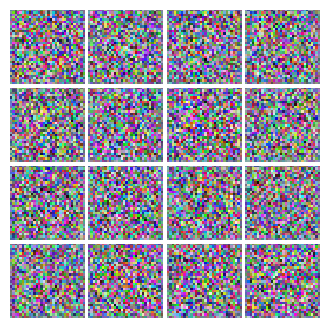


Iter: 1000, D: 1.253, G:0.8627


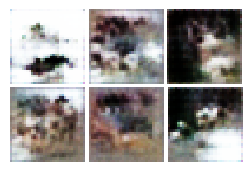

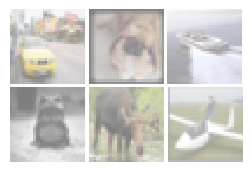

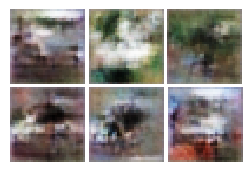

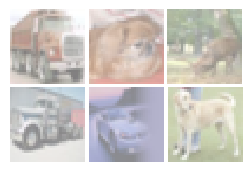

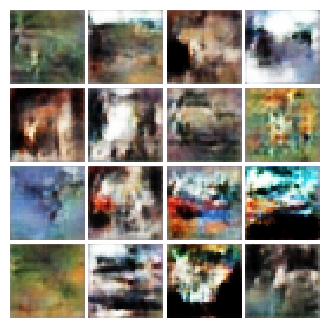


Iter: 2000, D: 0.831, G:1.166


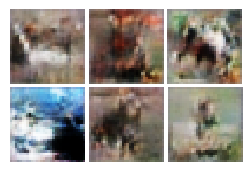

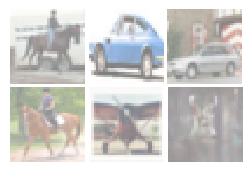

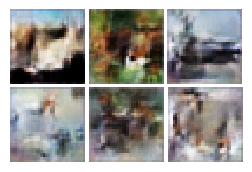

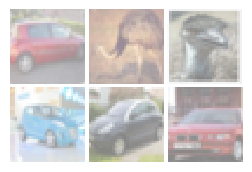

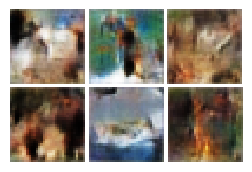

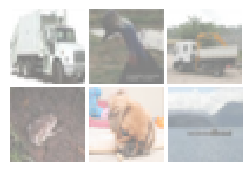

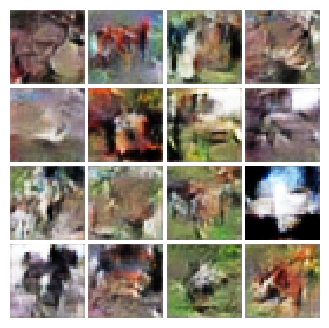


Iter: 3000, D: 0.6993, G:1.739


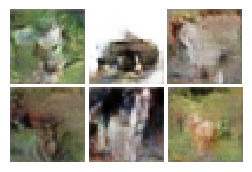

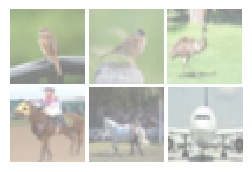

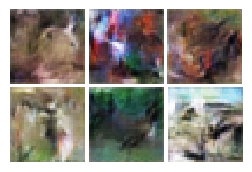

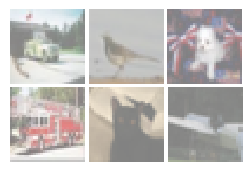

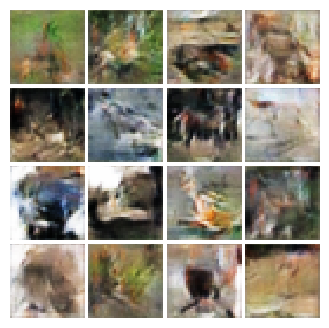


Iter: 4000, D: 0.725, G:1.423


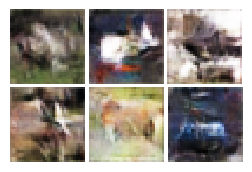

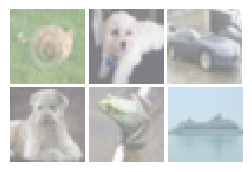

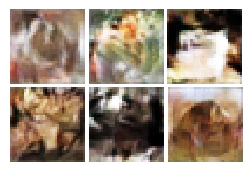

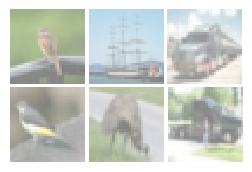

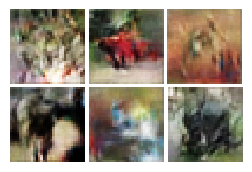

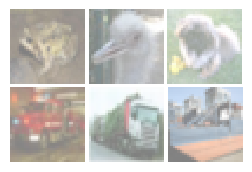

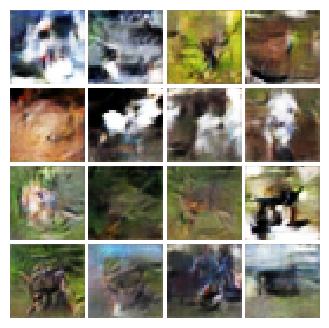


Iter: 5000, D: 0.6951, G:2.886


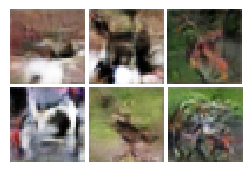

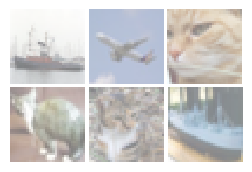

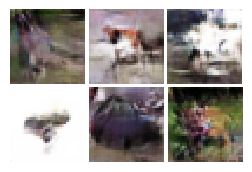

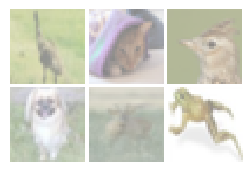

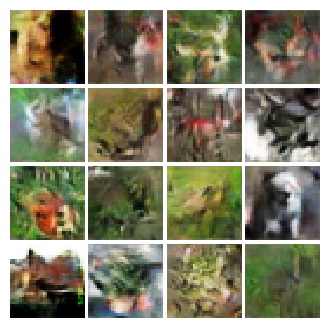


Iter: 6000, D: 0.3596, G:2.839


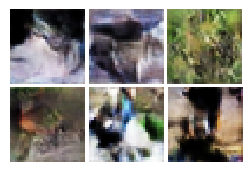

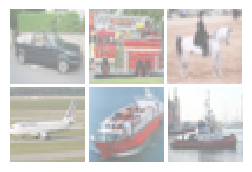

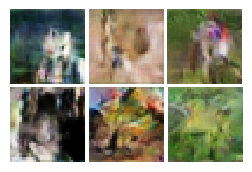

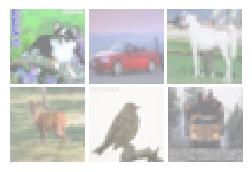

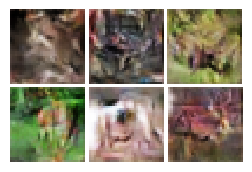

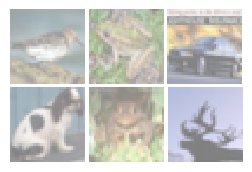

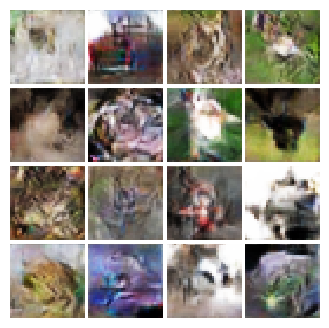


Iter: 7000, D: 0.4432, G:3.115


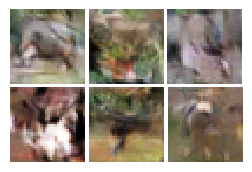

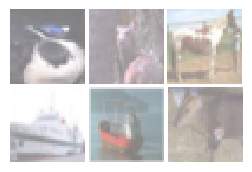

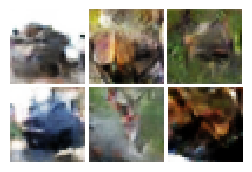

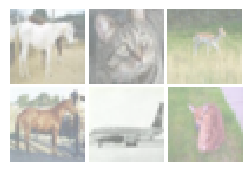

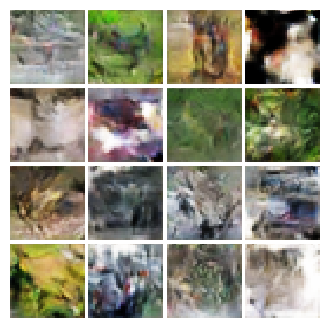


Iter: 8000, D: 0.2471, G:3.864


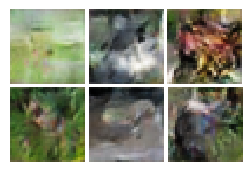

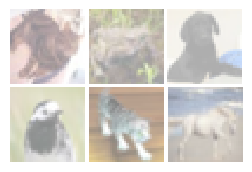

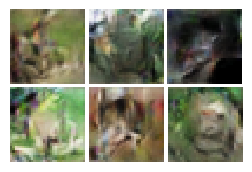

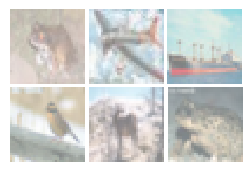

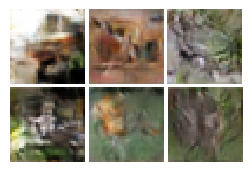

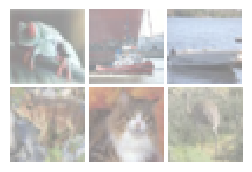

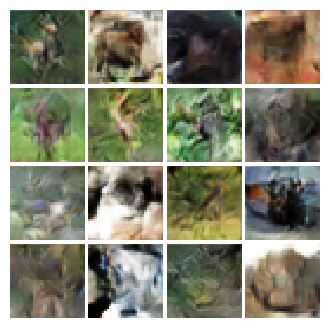


Iter: 9000, D: 0.3483, G:4.55


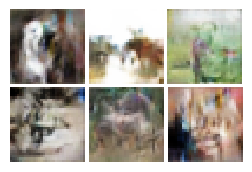

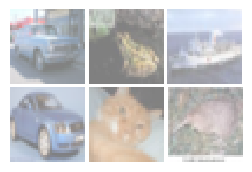

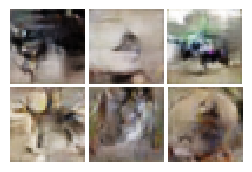

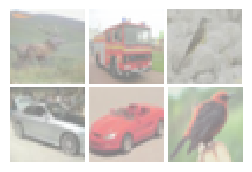

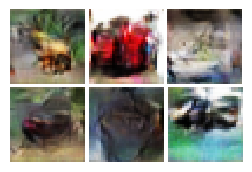

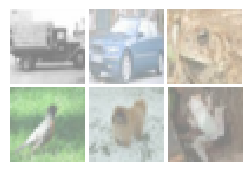

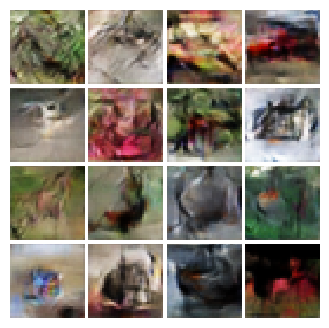

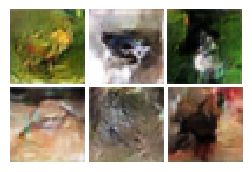

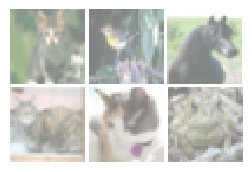

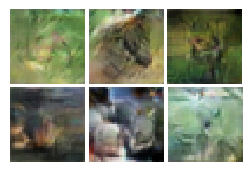

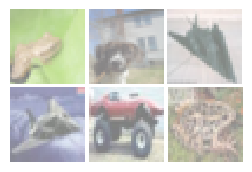

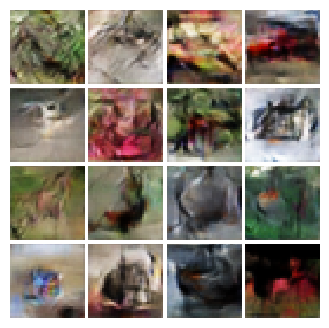

In [81]:
reset_seed(0)

D_DC = build_dc_classifier().to(device) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().to(device)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, 'dc_gan_results.jpg', num_epochs=25)

**The above image-grids contain grids of fake and real images for every epoch(25) and the trained model image for every 1000 iterations**

In [82]:
from FID import fidScore
dcgan_FID = []
for i in range(1,26):
    fids = fidScore('images/fakes','images/reals',  i, 1)
    print(f'Epoch:{i} and FID Score: {fids}', flush=True)
    dcgan_FID.append(fids)

Epoch:1 and FID Score: 148.27445838550642
Epoch:2 and FID Score: 111.20519933598825
Epoch:3 and FID Score: 65.89933139360534
Epoch:4 and FID Score: 46.335446881739244
Epoch:5 and FID Score: 35.58561139856036
Epoch:6 and FID Score: 28.830930965270838
Epoch:7 and FID Score: 24.207892134507816
Epoch:8 and FID Score: 20.850935227804257
Epoch:9 and FID Score: 18.30534536141701
Epoch:10 and FID Score: 16.310060919790587
Epoch:11 and FID Score: 14.704787240672758
Epoch:12 and FID Score: 13.385781783476304
Epoch:13 and FID Score: 12.282992865494933
Epoch:14 and FID Score: 11.347442979242082
Epoch:15 and FID Score: 10.543875277216287
Epoch:16 and FID Score: 9.846270883483157
Epoch:17 and FID Score: 9.235012099139553
Epoch:18 and FID Score: 8.695035745766972
Epoch:19 and FID Score: 8.214583854976432
Epoch:20 and FID Score: 7.784344776258578
Epoch:21 and FID Score: 7.396850369035537
Epoch:22 and FID Score: 7.046041993282046
Epoch:23 and FID Score: 6.726951456880318
Epoch:24 and FID Score: 6.43547

#### Latent Space Interpolation
As we did with our VAE, our final test of our trained GAN model is to perform interpolation in the latent space. We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them; we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors. For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

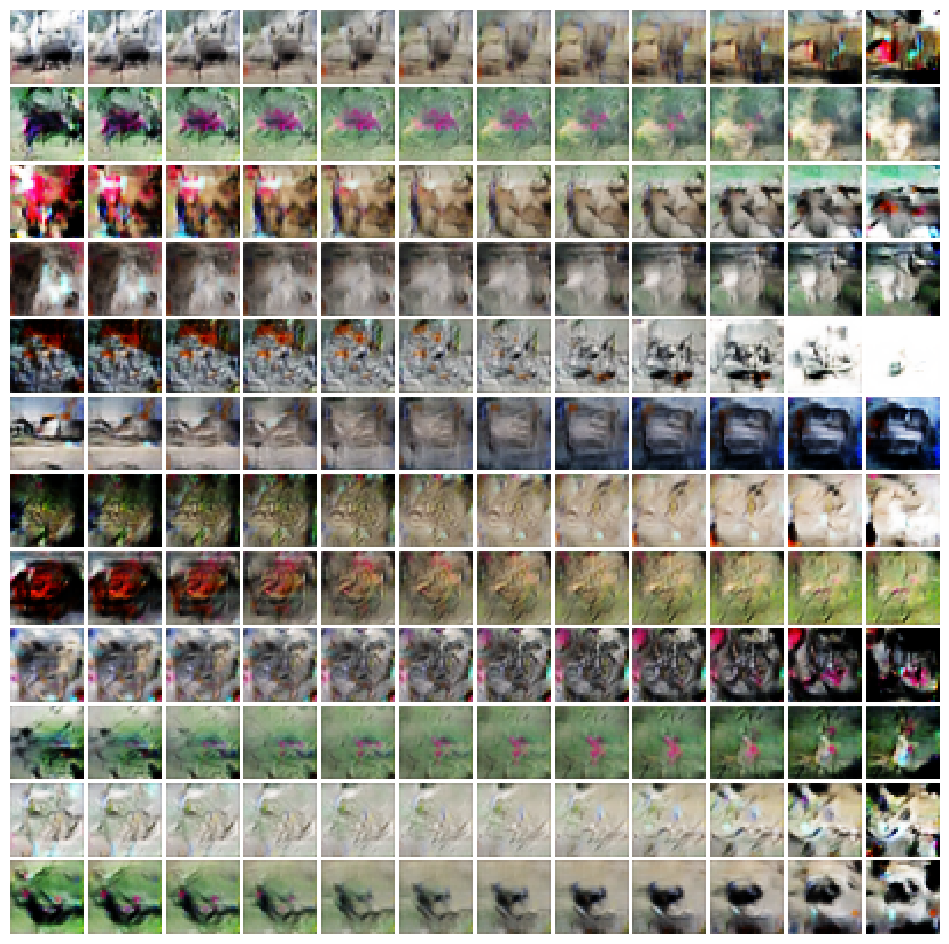

In [117]:
S = 12
z0 = sample_noise(S, NOISE_DIM, device=device)
z1 = sample_noise(S, NOISE_DIM, device=device)
torw = torch.linspace(0, 1, S, device=device).view(S, 1, 1)
cal = (torw * z0 + (1 - torw) * z1).transpose(0, 1).reshape(S * S, NOISE_DIM)

x = G_DC(cal)
show_cifar_images(x.data.cpu())

Text(0.5, 0, 'Epochs')

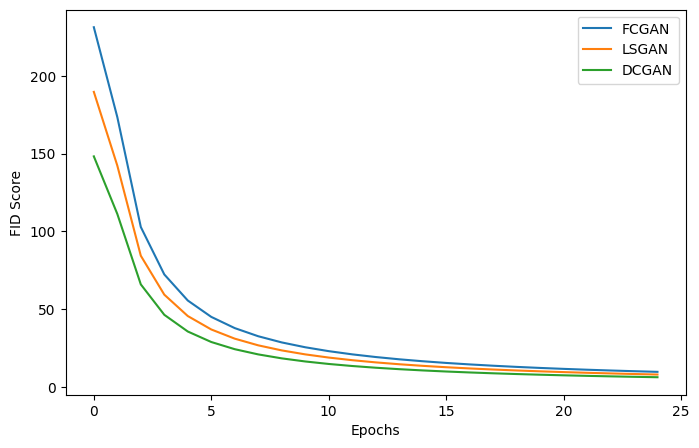

In [115]:
#Evaluation matrix
import numpy as np
iters =25

fig = plt.figure(figsize = (8, 5))

plt.plot(np.arange(iters), fcgan_FID, label='FCGAN')
plt.plot(np.arange(iters), lsgan_FID, label='LSGAN')
plt.plot(np.arange(iters), dcgan_FID, label='DCGAN')
plt.legend()
plt.ylabel('FID Score')
plt.xlabel('Epochs')

## Evaluation methodology

The Frechet Inception Distance score(FID) is a metric that calculates the distance between feature vectors calculated for real and generated images.The score summarizes how similar the two groups are in terms of statistics on computer vision features of the raw images calculated using the inception v3 model used for image classification. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical.The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.

Text(0, 0.5, 'FID Score')

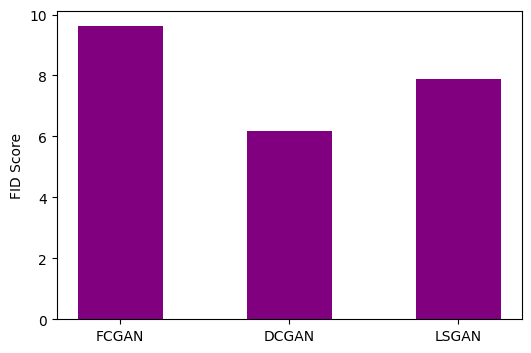

In [116]:
#FID values for all the three gans

scores = {'FCGAN':fcgan_FID[-1],
          'DCGAN':dcgan_FID[-1],
          'LSGAN':lsgan_FID[-1]
}
fig = plt.figure(figsize = (6, 4))
x = list(scores.keys())
y = list(scores.values())
plt.bar(x, y, color='purple', width=0.5)
plt.ylabel('FID Score')

### Result Analysis

After evaluating FC, DC and LS GANs based on FID(Frechet Inception Distance) score and observing the related images, I have understood that this is a great metric to evaluate images based on their colour due to it's sensitivity to small changes in the real distribution.The sample size to calculate FID has to be large enough (usually above 50K). Smaller sample
sizes can lead to over-estimation of the actual FID. Considering the limited resources I was working with, I ran 25 epochs for all the three models, the shapes and sizes of the output images were blurrier than what I was expecting from the model. When I compared all the three GAN models in terms of shape, size, clarity, noise and colour, DCGAN has performed better than the rest. 

## Final Check
Make sure all your training results (loss + images) are saved in the notebook. You can run "Runtime -> Restart and run all..." to double check before submitting